In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk

nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm


MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to("cuda")

def process_batch(texts):

    encoded_batch = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        logits = model(**encoded_batch).logits
        scores = logits.softmax(dim=-1).cpu().numpy()
    return scores


def process_large_dataframe(df, batch_size=32):
    results = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df['text'].iloc[i:i+batch_size].tolist()
        batch_scores = process_batch(batch_texts)
        results.extend(batch_scores)
    return results


df = pd.read_csv("text.csv")


batch_size = 32
scores = process_large_dataframe(df, batch_size=batch_size)


scores_df = pd.DataFrame(scores, columns=["roberta_neg", "roberta_neu", "roberta_pos"])


df = pd.concat([df.reset_index(drop=True), scores_df], axis=1)

df.head()


100%|██████████| 4376/4376 [25:14<00:00,  2.89it/s]


,Unnamed: 0,review,rating,text,company,roberta_neg,roberta_neu,roberta_pos
0,0,PERFECTION,5,First: you had the books I wanted for a gift t...,bookshop.org,0.002093,0.029654,0.968253
1,1,Good book buying experience,5,Great communication about my order. Books arri...,bookshop.org,0.003136,0.015224,0.981640
2,2,I appreciate the selection and the…,5,I appreciate the selection and the prices of t...,bookshop.org,0.002250,0.018527,0.979223
3,3,The books arrived in a very timely…,5,The books arrived in a very timely fashion and...,bookshop.org,0.005400,0.146323,0.848277
4,4,"Quick delivery, fab products",5,Beautiful books delivered extremely quickly co...,bookshop.org,0.001641,0.010469,0.987889


In [9]:
df.to_csv("text_with_scores.csv", index=False)

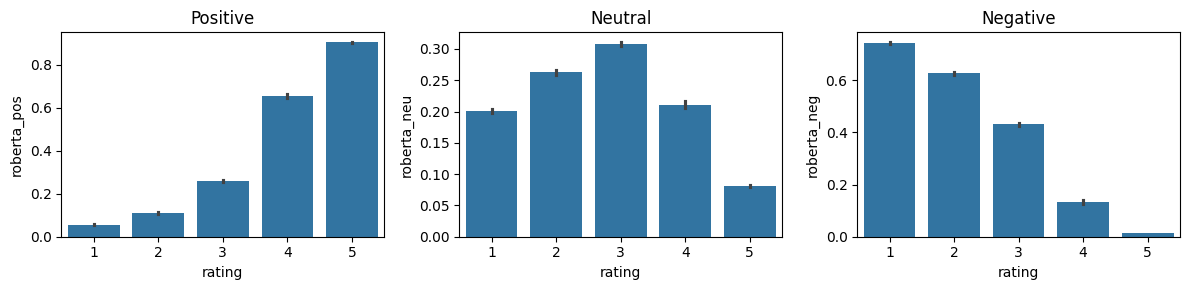

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='roberta_pos', ax=axs[0])
sns.barplot(data=df, x='rating', y='roberta_neu', ax=axs[1])
sns.barplot(data=df, x='rating', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()